In [8]:
import os
from azure.ai.projects import AIProjectClient
from azure.ai.projects.models import CodeInterpreterTool
from azure.identity import DefaultAzureCredential
from typing import Any
from pathlib import Path
from datetime import datetime



In [9]:
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(), conn_str=os.environ["PROJECT_CONNECTION_STRING"]
)

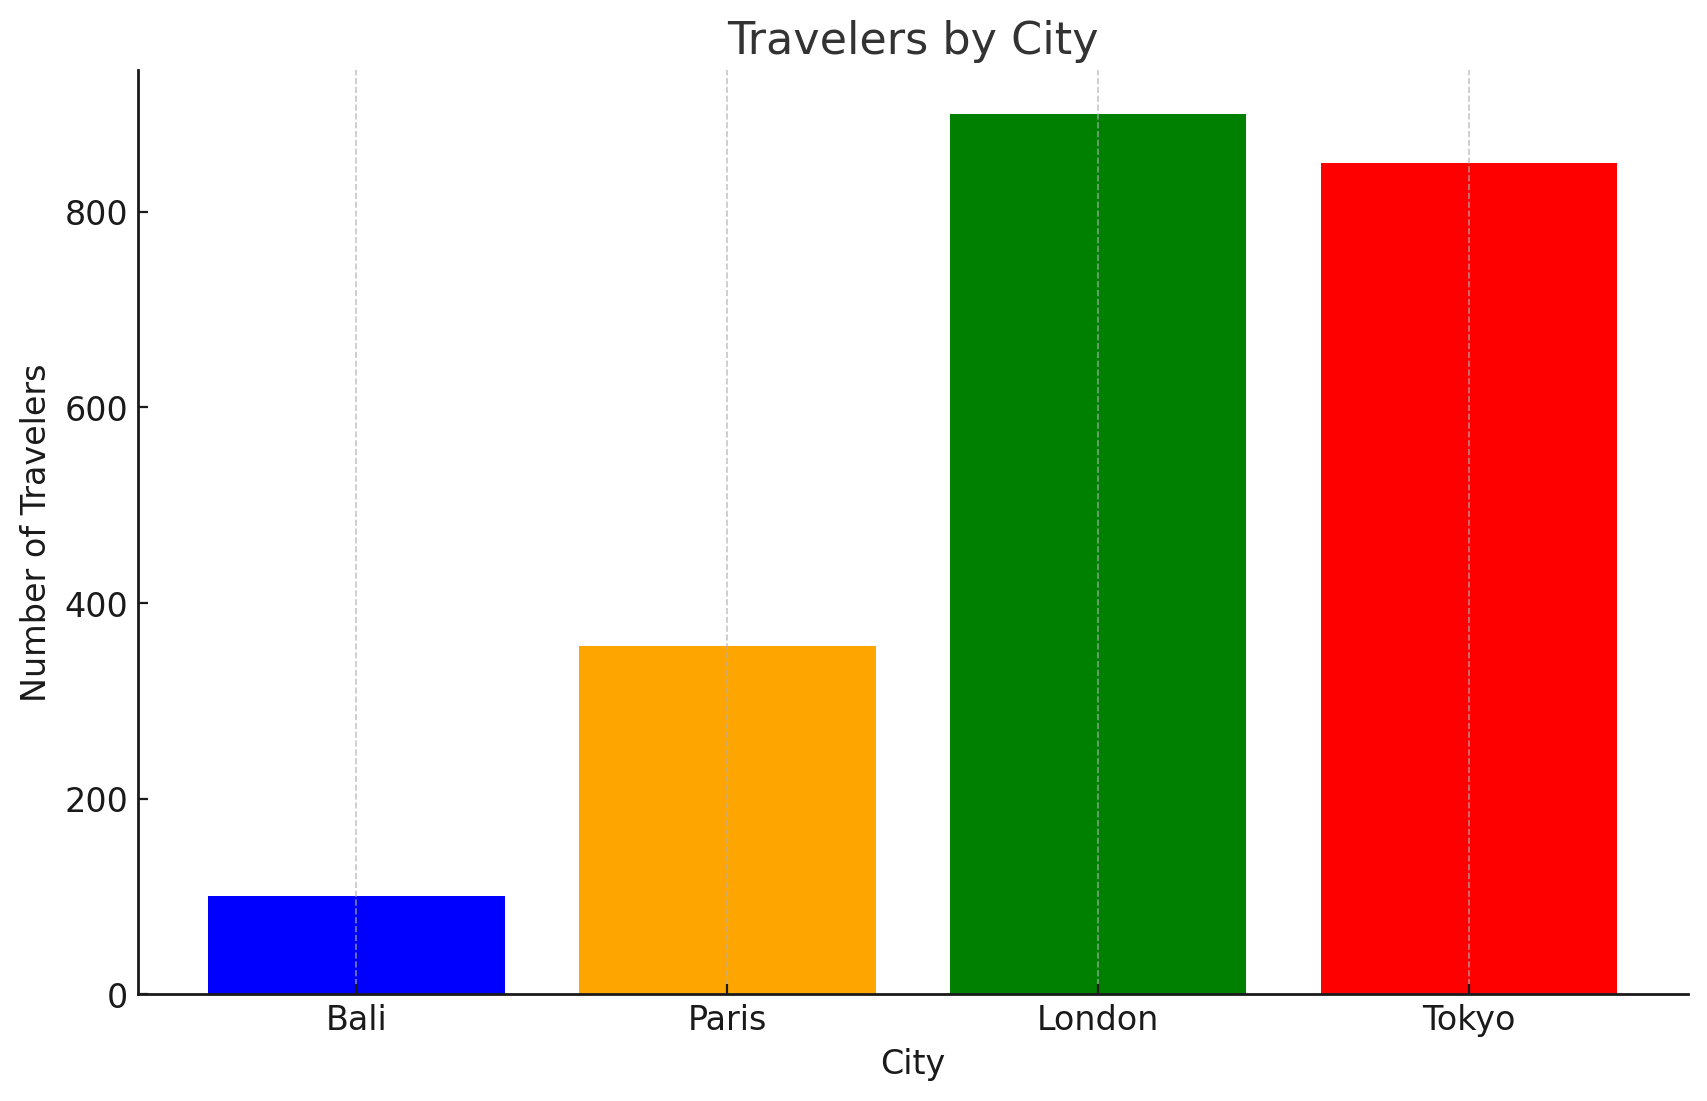

In [10]:
from IPython.display import display, HTML, Image
from pathlib import Path


async def run_agent_with_visualization():
    html_output = "<h2>Azure AI Agent Execution</h2>"

    with project_client:
        # Create an instance of the CodeInterpreterTool
        code_interpreter = CodeInterpreterTool()

        # The CodeInterpreterTool needs to be included in creation of the agent
        # Ensure to set the correct model name as deployed in Azure AI Foundry for your use case
        agent = project_client.agents.create_agent(
            model="gpt-4o-mini",
            name="my-agent",
            instructions="You are helpful agent",
            tools=code_interpreter.definitions,
            tool_resources=code_interpreter.resources,
        )
        html_output += f"<div><strong>Created agent</strong> with ID: {agent.id}</div>"

        # Create a thread
        thread = project_client.agents.create_thread()
        html_output += f"<div><strong>Created thread</strong> with ID: {thread.id}</div>"

        # User query - display nicely
        user_query = "Could you please create a bar chart for the operating profit using the following data and provide the file to me? Bali: 100 Travelers, Paris: 356 Travelers, London: 900 Travelers, Tokyo: 850 Travellers"
        html_output += "<div style='margin:15px 0; padding:10px; background-color:#f5f5f5; border-left:4px solid #007bff; border-radius:4px;'>"
        html_output += "<strong>User:</strong><br>"
        html_output += f"<div style='margin-left:15px'>{user_query}</div>"
        html_output += "</div>"

        # Create a message
        message = project_client.agents.create_message(
            thread_id=thread.id,
            role="user",
            content=user_query,
        )

        # Run the agent - show a "processing" message
        display(HTML(
            html_output + "<div style='color:#007bff'><i>Processing request...</i></div>"))

        # Execute the run
        run = project_client.agents.create_and_process_run(
            thread_id=thread.id, agent_id=agent.id)

        # Update status
        status_color = 'green' if run.status == 'completed' else 'red'
        html_output += f"<div><strong>Run finished</strong> with status: <span style='color:{status_color}'>{run.status}</span></div>"

        if run.status == "failed":
            html_output += f"<div style='color:red'><strong>Run failed:</strong> {run.last_error}</div>"

        # Get messages from the thread
        messages = project_client.agents.list_messages(thread_id=thread.id)

        # Format assistant response
        html_output += "<div style='margin:15px 0; padding:10px; background-color:#f0f7ff; border-left:4px solid #28a745; border-radius:4px;'>"
        html_output += "<strong>Assistant:</strong><br>"

        # Handle messages based on the actual structure
        # First, try to get the assistant's text responses
        try:
            # First approach - if messages is a list of objects with role attribute
            assistant_msgs = [msg for msg in messages if hasattr(
                msg, 'role') and msg.role == "assistant"]

            if assistant_msgs:
                last_msg = assistant_msgs[-1]
                if hasattr(last_msg, 'content'):
                    if isinstance(last_msg.content, list):
                        for content_item in last_msg.content:
                            if hasattr(content_item, 'type') and content_item.type == "text":
                                html_output += f"<div style='margin-left:15px; white-space:pre-wrap'>{content_item.text.value}</div>"
                    elif isinstance(last_msg.content, str):
                        html_output += f"<div style='margin-left:15px; white-space:pre-wrap'>{last_msg.content}</div>"

            # If no messages were found with the above approach, try a different structure
            if not assistant_msgs:
                # If messages is a class with attributes
                if hasattr(messages, 'data'):
                    for msg in messages.data:
                        if hasattr(msg, 'role') and msg.role == "assistant":
                            if hasattr(msg, 'content'):
                                html_output += f"<div style='margin-left:15px; white-space:pre-wrap'>{msg.content}</div>"

        except Exception as e:
            html_output += f"<div style='color:red'><strong>Error processing messages:</strong> {str(e)}</div>"

        html_output += "</div>"

        # Handle image contents based on the actual structure
        saved_images = []
        try:
            # Try to access image_contents as an attribute
            if hasattr(messages, 'image_contents'):
                for image_content in messages.image_contents:
                    file_id = image_content.image_file.file_id
                    file_name = f"{file_id}_image_file.png"
                    project_client.agents.save_file(
                        file_id=file_id, file_name=file_name)
                    saved_images.append(file_name)
                    html_output += f"<div style='margin-top:10px'><strong>Generated Image:</strong> {file_name}</div>"
        except Exception as e:
            html_output += f"<div style='color:orange'><i>Note: No images found or error processing images</i></div>"

        # Handle file path annotations based on the actual structure
        try:
            # Try to access file_path_annotations as an attribute
            if hasattr(messages, 'file_path_annotations'):
                for file_path_annotation in messages.file_path_annotations:
                    file_name = Path(file_path_annotation.text).name
                    project_client.agents.save_file(
                        file_id=file_path_annotation.file_path.file_id, file_name=file_name)
                    html_output += "<div style='margin:10px 0; padding:8px; background-color:#f8f9fa; border:1px solid #ddd; border-radius:4px;'>"
                    html_output += f"<strong>Generated File:</strong> {file_name}<br>"
                    html_output += f"<strong>Type:</strong> {file_path_annotation.type}<br>"
                    html_output += "</div>"
        except Exception as e:
            html_output += f"<div style='color:orange'><i>Note: No file annotations found or error processing files</i></div>"

        # Delete the agent once done
        project_client.agents.delete_agent(agent.id)
        html_output += "<div style='margin-top:10px'><i>Agent deleted after completion</i></div>"

        # Final display of all content
        display(HTML(html_output))

        # Display any saved images
        for img_file in saved_images:
            display(Image(img_file))

# Execute the function
await run_agent_with_visualization()